### 0. Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os

os.chdir("../")
from scripts import utils
from pathlib import Path
import matplotlib.gridspec as gridspec
from tqdm.auto import tqdm

In [2]:
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
from mlxtend.evaluate import feature_importance_permutation
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.utils.estimator_checks import check_estimator
from mlxtend.feature_selection import (
    SequentialFeatureSelector,
)
from sklearn.model_selection import cross_val_predict, train_test_split
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef
import matplotlib.ticker as ticker
import distclassipy as dcpy

In [4]:
with open("settings.txt") as f:
    settings_dict = json.load(f)
seed_val = settings_dict["seed_choice"]
np.random.seed(seed_val)
sns_dict = settings_dict["sns_dict"]
sns.set_theme(**sns_dict)

In [5]:
all_metrics = settings_dict["all_metrics"]

In [6]:
features = pd.read_parquet("data/reduced_balancedfeatures_LATEST.parquet")
features["class"].value_counts()

class
CEP     683
DSCT    683
EB      683
RRL     683
Name: count, dtype: int64

In [7]:
features = features.sample(frac=1)

In [8]:
y_df = features["class"]
X_df = features.drop(["Coordinate_x", "Coordinate_y", "Coordinate_z", "class"], axis=1)

In [9]:
y = y_df.to_numpy()
X = X_df.to_numpy()

### 1. Isolation Forest

In [10]:
from sklearn.ensemble import IsolationForest
from scipy import stats

In [11]:
clf = IsolationForest(max_samples=100, contamination=0.1, random_state=100)
clf.fit(X) #, sample_weight=1.0/(Xfixed[:,2,:])**2)
scores_pred_Norm = clf.decision_function(X)
#scores_pred_Norm = clf.score_samples(X)
#.sample_score(X)

threshold_Norm  = stats.scoreatpercentile(scores_pred_Norm ,100 * 0.1)
y_predNorm = clf.predict(X)

In [12]:
abornmality = -scores_pred_Norm
iforest_df = pd.DataFrame(abornmality, columns=["abnormality"]) # higher is more abnormal
iforest_df.index.name = "sample_num"
iforest_df=iforest_df.sort_values(by="abnormality", ascending=False)

In [13]:
iforest_df

,abnormality
sample_num,
817,0.146213
2157,0.138299
1969,0.128877
157,0.122814
2543,0.118233
...,...
1220,-0.135107
1320,-0.135398
1806,-0.135956


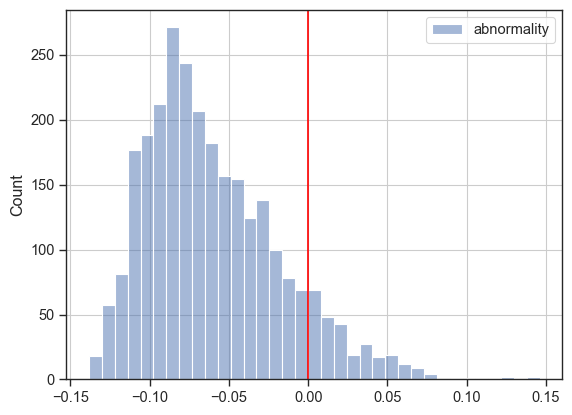

In [14]:
sns.histplot(iforest_df)
plt.axvline(x=0, color="red",label="outlier boundary")
plt.show()

### 2. Single DCPY Mean Distance

In [15]:
lcdc = dcpy.DistanceMetricClassifier(
    scale=True,
    central_stat="median",
    dispersion_stat="std",
)
lcdc.fit(X,y)

DistanceMetricClassifier()

In [16]:
for metric in tqdm(all_metrics, desc="Metric", leave=True):
    metric_str = utils.get_metric_name(metric)
    _ = lcdc.predict_and_analyse(X, metric=metric)

    dist_df = lcdc.centroid_dist_df_
    break

Metric:   0%|          | 0/18 [00:00<?, ?it/s]

In [17]:
dist_df['closest_distance'] = dist_df.min(axis=1)

# standard scale w/mean?
mean = dist_df['closest_distance'].mean()
std  = dist_df['closest_distance'].std()
dist_df['abnormality_mean'] = (dist_df['closest_distance'] - mean) / std

# standard scale w/median?
med = dist_df['closest_distance'].median()
mad = stats.median_abs_deviation(dist_df['closest_distance'])
dist_df['abnormality_median'] = (dist_df['closest_distance'] - med) / mad

dist_df.index.name = "sample_num"
dist_df=(dist_df.sort_values(by="abnormality_mean",ascending=False))

In [18]:
dist_df

,CEP_dist,DSCT_dist,EB_dist,RRL_dist,closest_distance,abnormality_mean,abnormality_median
sample_num,,,,,,,
1698,2.221283e+06,4.421163e+06,4.555621e+01,5.301515e+06,45.556213,13.357850,34.852994
1592,3.431627e+01,8.980047e+02,5.600783e+04,1.275726e+04,34.316274,9.352996,24.548565
1062,3.212941e+01,4.580644e+02,7.057781e+03,2.917023e+03,32.129409,8.573804,22.543715
568,3.241179e+01,6.444508e+01,2.663454e+02,3.044971e+01,30.449705,7.975316,21.003814
1242,3.188868e+05,4.514984e+02,5.016597e+07,2.977814e+01,29.778138,7.736033,20.388142
...,...,...,...,...,...,...,...
2131,7.834741e+00,2.119640e+01,7.771283e+00,4.064401e+00,4.064401,-1.425917,-3.185419
1220,7.356471e+00,4.044531e+00,1.146505e+01,7.671534e+00,4.044531,-1.432996,-3.203635
1762,7.573406e+00,3.821672e+00,7.020998e+00,7.472453e+00,3.821672,-1.512403,-3.407945


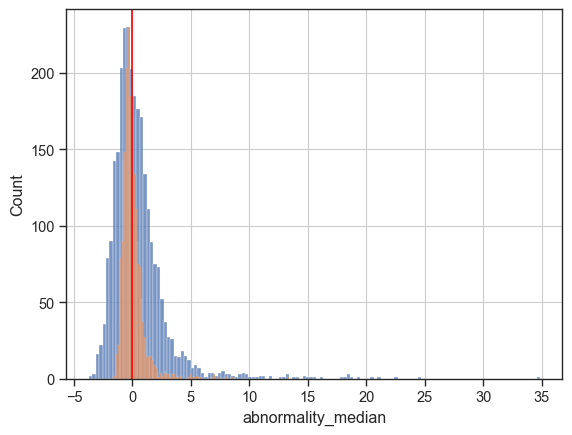

In [19]:
sns.histplot(dist_df,x="abnormality_median")
sns.histplot(dist_df,x="abnormality_mean")
plt.axvline(x=0, color="red")
# plt.yscale("log")
plt.show()

In [20]:
dist_df["abnormality_iforest"] = iforest_df.loc[dist_df.index]

In [21]:
anomaly_df = dist_df.loc[:,["abnormality_mean","abnormality_median","abnormality_iforest"]]
anomaly_df=anomaly_df.sort_values(by=["abnormality_mean","abnormality_median","abnormality_iforest"],ascending=False)

In [22]:
anomaly_df[(anomaly_df["abnormality_mean"] > 0) | (anomaly_df["abnormality_median"] > 0) | (anomaly_df["abnormality_iforest"] > 0)]

,abnormality_mean,abnormality_median,abnormality_iforest
sample_num,,,
1698,13.357850,34.852994,0.065768
1592,9.352996,24.548565,0.055202
1062,8.573804,22.543715,0.037101
568,7.975316,21.003814,0.000071
1242,7.736033,20.388142,0.042030
...,...,...,...
480,-0.333006,-0.373376,0.006184
462,-0.351599,-0.421214,0.002476
2602,-0.354475,-0.428615,0.005951


In [23]:
from sklearn.preprocessing import MinMaxScaler

In [24]:
for col in anomaly_df.columns:
    scaler = MinMaxScaler(feature_range=(-1, 1))
    anomaly_df[col] = scaler.fit_transform(anomaly_df[[col]]).ravel()

<Axes: ylabel='sample_num'>

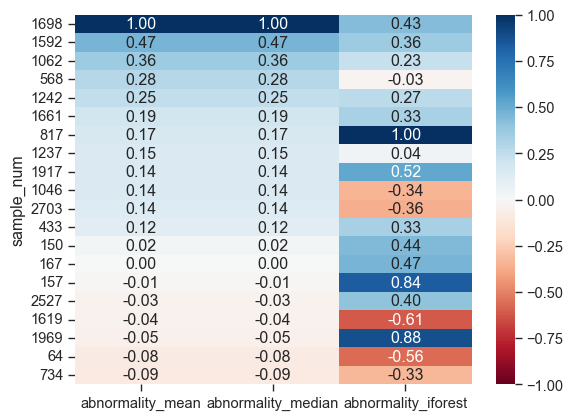

In [25]:
sns.heatmap(anomaly_df.iloc[:20],cmap="RdBu", annot=True, fmt=".2f",vmin=-1,vmax=1)

<Axes: ylabel='sample_num'>

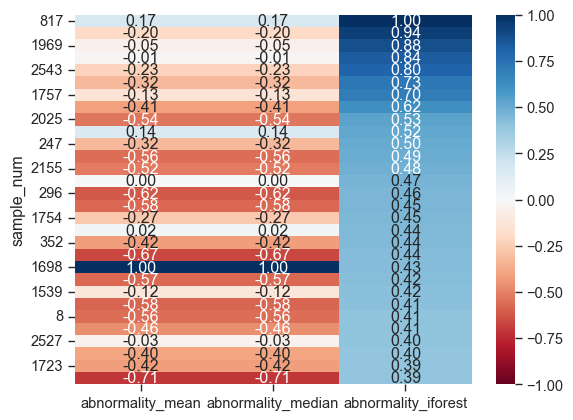

In [26]:
sns.heatmap(anomaly_df.sort_values("abnormality_iforest",ascending=False).iloc[:30],cmap="RdBu", annot=True, fmt=".2f",vmin=-1,vmax=1)

### 3. Many DCPY Distance

In [27]:
dist_df_dict = {}
for metric in tqdm(all_metrics, desc="Metric", leave=True):
    metric_str = utils.get_metric_name(metric)
    _ = lcdc.predict_and_analyse(X, metric=metric)

    dist_df = lcdc.centroid_dist_df_

    dist_df['closest_distance'] = dist_df.min(axis=1)
    
    # standard scale w/mean?
    mean = dist_df['closest_distance'].mean()
    std  = dist_df['closest_distance'].std()
    dist_df['abnormality_mean'] = (dist_df['closest_distance'] - mean) / std
    
    # standard scale w/median?
    med = dist_df['closest_distance'].median()
    mad = stats.median_abs_deviation(dist_df['closest_distance'])
    dist_df['abnormality_median'] = (dist_df['closest_distance'] - med) / mad
    
    dist_df.index.name = "sample_num"
    #dist_df=(dist_df.sort_values(by="abnormality_mean",ascending=False))
    dist_df_dict[metric_str] = dist_df

Metric:   0%|          | 0/18 [00:00<?, ?it/s]

In [28]:
bigarr = []
for metric in tqdm(all_metrics, desc="Metric", leave=True):
    metric_str = utils.get_metric_name(metric)
    bigarr.append(dist_df_dict[metric_str].loc[:,["abnormality_mean","abnormality_median"]].to_numpy())

Metric:   0%|          | 0/18 [00:00<?, ?it/s]

In [29]:
mean_alldist_abnormalities = np.array(bigarr).mean(axis=0)
median_alldist_abnormalities = np.median(np.array(bigarr),axis=0)

In [30]:
pd.DataFrame(,index=dist_df_dict[metric_str].index, column)

SyntaxError: invalid syntax (2442082617.py, line 1)